In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
import os
from data_preprocessing import FilteringCurves, ShowResponseCurves
from fitting_curves import FittingColumn, ShowResponseCurvesWithFitting, compute_r2_score
_FOLDER = "./data/"

In [24]:
def TrainTestKernelByDrug(train_data, test_data, drug_ids, number_coefficients, kernel='linear', 
                          kernel_dict=None, kernel_param = None,
                          alpha=1, gamma=None, degree=3, coef0=1):
    
    conc_columns= ["fd_num_"+str(i) for i in range(10)]
    response_norm = ['norm_cells_'+str(i) for i in range(10)]
    param_cols = ["param_"+str(i) for i in range(1,5)]
    df_results = test_data[['COSMIC_ID', 'DRUG_ID'] + conc_columns + response_norm + param_cols].copy()
    
    #check whether each coefficient needs its own parameters

    for drug_id in drug_ids:
        indexes_train = train_data[train_data["DRUG_ID"]==drug_id].index
        indexes_test = test_data[test_data["DRUG_ID"]==drug_id].index
    
        X_train = train_data.loc[indexes_train, train_data.columns[26:-4]].values
        X_test = test_data.loc[indexes_test, test_data.columns[26:-4]].values
    
        for i in range(number_coefficients):
            #check whether each coefficient needs its own parameters
            if kernel_dict:
                kernel = kernel_dict[i+1]
                alpha_value = np.float32(kernel_param[kernel]["alpha"][i+1])
                try:
                    gamma_value = np.float32(kernel_param[kernel]["gamma"][i+1])
                    degree_value = np.float32(kernel_param[kernel]["degree"][i+1])
                    coef0_value = np.float32(kernel_param[kernel]["coef0"][i+1])
                except:
                    gamma_value = gamma
                    degree_value = degree
                    coef0_value = coef0
            #if kernel is a string (i.e the same for all parameters)
            else:
                if type(alpha)==dict:
                    alpha_value = alpha[i+1]
                else:
                    alpha_value = alpha
                
                if type(gamma)==dict:
                    gamma_value = gamma[i+1]
                else:
                    gamma_value = gamma
            
                if type(degree)==dict:
                    degree_value = degree[i+1]
                else:
                    degree_value = degree
                
                if type(coef0)==dict:
                    coef0_value = coef0[i+1]
                else:
                    coef0_value = coef0
            
            y_train = train_data.loc[indexes_train, "param_"+str(i+1)].values

            kernel_model = KernelRidge(kernel = kernel, alpha = alpha_value, gamma=gamma_value, 
                                 degree=degree_value, coef0=coef0_value)
            
            kernel_model.fit(X_train, y_train)
            y_pred = kernel_model.predict(X_test)
            df_results.loc[indexes_test, "pred_param_"+str(i+1)] = y_pred
        
    return df_results

def ComputeErrorByDrug(df_results, number_coefficients, metrics="mse"):
    df_errors_test = pd.DataFrame()
    for drug_id in df_results["DRUG_ID"].unique():
        for i in range(number_coefficients):
            drug_index = df_results[df_results["DRUG_ID"]==drug_id].index
            y_test = df_results.loc[drug_index, "param_"+str(i+1)]
            y_pred = df_results.loc[drug_index, "pred_param_"+str(i+1)]
            if metrics == "mse":
                error = mean_squared_error(y_test, y_pred)
            elif metrics == "mae":
                error = mean_absolute_error(y_test, y_pred)
            else:
                print("ERROR: Unknown metrics")
            df_errors_test.loc[drug_id, metrics+"_coef_"+str(i+1)] = error
    return df_errors_test

In [4]:
os.listdir("./results/")

['merged_drug_profiles_sigmoid4_23.csv',
 'filtered_drug_profiles_13.csv',
 'filtered_drug_profiles_12.csv',
 'filtered_drug_profiles_23.csv',
 'filtered_drug_profiles.csv',
 'merged_drug_profiles_sigmoid4_123.csv',
 'filtered_drug_profiles_123.csv']

In [5]:
# NEED TO CHANGE - what file to read
df = pd.read_csv("./results/merged_drug_profiles_sigmoid4_123.csv")
df.shape

(2612, 1100)

In [6]:
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

In [7]:
cell_features = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep="\t")

stat_data = df.groupby(["DRUG_ID"])[["COSMIC_ID"]].count().rename(columns={"COSMIC_ID": "count_cell_lines"})\
            .sort_values("count_cell_lines", ascending=False)
    

drug_features = pd.read_csv(_FOLDER+'/Drug_Features.csv').rename(columns = {"Drug ID": "DRUG_ID"})
statistics = pd.merge(left = stat_data, right = drug_features, how= "left", on = "DRUG_ID").sort_values("count_cell_lines", ascending =False)
statistics.head(10)

,DRUG_ID,count_cell_lines,Drug Name,Synonyms,Target,Target Pathway
0,328,115,SNX-2112,SNX 2112,HSP90,Protein stability and degradation
1,272,107,AR-42,"HDAC-42, AR 42, AR42",HDAC1,Chromatin histone acetylation
2,273,106,CUDC-101,CUDC 101,"HDAC1-10, EGFR, ERBB2",Other
3,170,102,Shikonin,Anchusin,not defined,Other
4,274,100,Belinostat,"PXD101, PXD-101",HDAC1,Chromatin histone acetylation
5,276,100,CAY10603,-,"HDAC1, HDAC6",Chromatin histone acetylation
6,200,87,Dacinostat,"NVP-LAQ824, LAQ824",HDAC1,Chromatin histone acetylation
7,219,86,AT-7519,AT7519,"CDK1, CDK2, CDK4, CDK6, CDK9",Cell cycle
8,180,72,Thapsigargin,Octanoic acid,SERCA,Other
9,346,57,THZ-2-102-1,-,CDK7,Cell cycle


### Forming train and test sets with specified amount of each drug

In [8]:
%%time

# select subsets for each drug and divide each of them into train and test data
# concatenate all the train and test subsets

gr = df.groupby(["DRUG_ID"])["COSMIC_ID"].count()
good_drug_ids = gr[gr>50].index
len(good_drug_ids)

train = pd.DataFrame(columns=df.columns)
test = pd.DataFrame(columns=df.columns)

for drug_id in good_drug_ids:
    df_i = df[df["DRUG_ID"]==drug_id]
    np.random.seed(123)
    indexes = np.random.permutation(df_i.index)
    train_size = int(df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    
    train_set = df_i.loc[indexes_train, :]
    test_set = df_i.loc[indexes_test, :]
    
    train = pd.concat([train, train_set], axis=0)
    test = pd.concat([test, test_set], axis=0)
    
print(train.shape, test.shape)

(683, 1100) (300, 1100)
CPU times: user 466 ms, sys: 64.6 ms, total: 530 ms
Wall time: 535 ms


### Training and testing with only one kernel for all fitting coefficients

In [9]:
short_test = TrainTestKernelByDrug(train, test, good_drug_ids, number_coefficients=4, kernel='linear', alpha=1, gamma=None, degree=3, coef0=1)

# parameters: x0, L, k, b
# y = 1 / (L + np.exp(-k*(x-x0)))+b
# Wang 1.0 / (1.0 + np.exp((x-p)/s)   x - dosage [0, 1], p - position, s - shape parameter
short_test[['COSMIC_ID', 'DRUG_ID', "param_1","pred_param_1","param_2", "pred_param_2", 
            "param_3", "pred_param_3", "param_4", "pred_param_4"]].head()

fitting_cols = ["param_"+str(i) for i in range(1,5)]
pred_fitting_cols = ["pred_param_"+str(i) for i in range(1,5)]
fitting_function = "sigmoid_4_param"

short_test["r2_fitted"] = compute_r2_score(short_test, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=fitting_cols, fitting_function = fitting_function)

short_test["r2_predicted"] = compute_r2_score(short_test, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=pred_fitting_cols, fitting_function = fitting_function)

# only one case when predicted values was a better fit to original data than directly fitted
print("Predicted values give higher R2 than fitted:")
display(short_test[short_test["r2_predicted"]>short_test["r2_fitted"]][["DRUG_ID","r2_fitted", "r2_predicted"]])

print("Predicted values that give R2 >0.9:", short_test[short_test["r2_predicted"]>0.9][["DRUG_ID","r2_fitted", "r2_predicted"]].shape[0])
display(short_test[short_test["r2_predicted"]>0.9][["DRUG_ID","r2_fitted", "r2_predicted"]].head())
print("Results of direct fitting that gives R2 >0.9:", short_test[short_test["r2_fitted"]>0.9].shape[0])

Predicted values give higher R2 than fitted:


,DRUG_ID,r2_fitted,r2_predicted
1606,219,5.050434e-08,0.71805


Predicted values that give R2 >0.9: 22


,DRUG_ID,r2_fitted,r2_predicted
2419,170,0.998540,0.923729
500,219,0.997481,0.935583
1855,219,0.998097,0.919643
81,219,0.998477,0.918837
944,219,0.998660,0.947403


Results of direct fitting that gives R2 >0.9: 292


In [10]:
# for sigmoid function fitting showed that hyperparameters for all the coefficients are the same,
# and from the default values only gamma was different

short_test = TrainTestKernelByDrug(train, test, good_drug_ids, number_coefficients=4, kernel='sigmoid', 
                                   alpha=1, gamma=0.00001, degree=3, coef0=1)

# parameters: x0, L, k, b
# y = 1 / (L + np.exp(-k*(x-x0)))+b
# Wang 1.0 / (1.0 + np.exp((x-p)/s)   x - dosage [0, 1], p - position, s - shape parameter
short_test[['COSMIC_ID', 'DRUG_ID', "param_1","pred_param_1","param_2", "pred_param_2", 
            "param_3", "pred_param_3", "param_4", "pred_param_4"]].head()

fitting_cols = ["param_"+str(i) for i in range(1,5)]
pred_fitting_cols = ["pred_param_"+str(i) for i in range(1,5)]
fitting_function = "sigmoid_4_param"

short_test["r2_fitted"] = compute_r2_score(short_test, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=fitting_cols, fitting_function = fitting_function)

short_test["r2_predicted"] = compute_r2_score(short_test, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=pred_fitting_cols, fitting_function = fitting_function)

# only one case when predicted values was a better fit to original data than directly fitted
print("Predicted values give higher R2 than fitted:")
display(short_test[short_test["r2_predicted"]>short_test["r2_fitted"]][["DRUG_ID","r2_fitted", "r2_predicted"]])

print("Predicted values that give R2 >0.9:", short_test[short_test["r2_predicted"]>0.9][["DRUG_ID","r2_fitted", "r2_predicted"]].shape[0])
display(short_test[short_test["r2_predicted"]>0.9][["DRUG_ID","r2_fitted", "r2_predicted"]].head())
print("Results of direct fitting that gives R2 >0.9:", short_test[short_test["r2_fitted"]>0.9].shape[0])

Predicted values give higher R2 than fitted:


,DRUG_ID,r2_fitted,r2_predicted
1606,219,5.050434e-08,0.397983


Predicted values that give R2 >0.9: 56


,DRUG_ID,r2_fitted,r2_predicted
134,170,0.998072,0.975915
1076,170,0.999686,0.986524
742,170,0.999448,0.982892
1909,170,0.997694,0.970117
1768,170,0.999126,0.913019


Results of direct fitting that gives R2 >0.9: 292


### Training and testing tuned kernels

In [11]:
# master_tuning123.output Best Kernels for filtered data_123

best_parameters_kernels_123 = {
    "linear": {"alpha": {1: 200.0, 2: 100.0, 3: 100.0, 4: 50.0}},
               
    "sigmoid": {"gamma" :{1: 1e-05, 2: 1e-05, 3: 1e-05, 4: 0.01},
                "alpha":  {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0},
                "coef0" : {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}
               },
               
    "rbf" : {"gamma" : {1: 1e-05, 2: 1e-05, 3: 1e-04, 4: 1e-04},
           "alpha" : {1: 5.0, 2: 1.0, 3: 1.0, 4: 0.1}
          }, 
               
    "polynomial" : { "gamma" : {1: 1e-05, 2: 1e-05, 3: 1e-05, 4: 1e-04},
                    "degree" : {1: 1.0, 2: 1.0, 3: 1.0, 4: 5.0}, 
                    "alpha" : {1: 5.0, 2: 1.0, 3: 1.0, 4: 0.01}
                   }}
               
best_kernels = {1: 'sigmoid', 2: 'polynomial', 3: 'rbf', 4: 'polynomial'}

In [12]:
short_test = TrainTestKernelByDrug(train, test, good_drug_ids, number_coefficients=4, 
                                   kernel_dict=best_kernels, kernel_param = best_parameters_kernels_123)

# parameters: x0, L, k, b
# y = 1 / (L + np.exp(-k*(x-x0)))+b
# Wang 1.0 / (1.0 + np.exp((x-p)/s)   x - dosage [0, 1], p - position, s - shape parameter
short_test[['COSMIC_ID', 'DRUG_ID', "param_1","pred_param_1","param_2", "pred_param_2", 
            "param_3", "pred_param_3", "param_4", "pred_param_4"]].head()

fitting_cols = ["param_"+str(i) for i in range(1,5)]
pred_fitting_cols = ["pred_param_"+str(i) for i in range(1,5)]
fitting_function = "sigmoid_4_param"

short_test["r2_fitted"] = compute_r2_score(short_test, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=fitting_cols, fitting_function = fitting_function)

short_test["r2_predicted"] = compute_r2_score(short_test, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=pred_fitting_cols, fitting_function = fitting_function)

# only one case when predicted values was a better fit to original data than directly fitted
print("Predicted values give higher R2 than fitted:")
display(short_test[short_test["r2_predicted"]>short_test["r2_fitted"]][["DRUG_ID","r2_fitted", "r2_predicted"]])

print("Predicted values that give R2 >0.9:", short_test[short_test["r2_predicted"]>0.9][["DRUG_ID","r2_fitted", "r2_predicted"]].shape[0])
display(short_test[short_test["r2_predicted"]>0.9][["DRUG_ID","r2_fitted", "r2_predicted"]].head())
print("Results of direct fitting that gives R2 >0.9:", short_test[short_test["r2_fitted"]>0.9].shape[0])

Predicted values give higher R2 than fitted:


,DRUG_ID,r2_fitted,r2_predicted
1606,219,5.050434e-08,0.482504


Predicted values that give R2 >0.9: 56


,DRUG_ID,r2_fitted,r2_predicted
134,170,0.998072,0.967177
1076,170,0.999686,0.988993
742,170,0.999448,0.982212
1909,170,0.997694,0.967595
1768,170,0.999126,0.916483


Results of direct fitting that gives R2 >0.9: 292


**Conclusions:** Applying the similar sigmoid kernel to all coefficients gives almost the same results as usage of different kernels to each coefficient

### Analysis of the best kernel learnning

In [13]:
# for sigmoid function fitting showed that hyperparameters for all the coefficients are the same,
# and from the default values only gamma was different

short_test = TrainTestKernelByDrug(train, test, good_drug_ids, number_coefficients=4, kernel='sigmoid', 
                                   alpha=1, gamma=0.00001, degree=3, coef0=1)

# parameters: x0, L, k, b
# y = 1 / (L + np.exp(-k*(x-x0)))+b
# Wang 1.0 / (1.0 + np.exp((x-p)/s)   x - dosage [0, 1], p - position, s - shape parameter
short_test[['COSMIC_ID', 'DRUG_ID', "param_1","pred_param_1","param_2", "pred_param_2", 
            "param_3", "pred_param_3", "param_4", "pred_param_4"]].head()

fitting_cols = ["param_"+str(i) for i in range(1,5)]
pred_fitting_cols = ["pred_param_"+str(i) for i in range(1,5)]
fitting_function = "sigmoid_4_param"

short_test["r2_fitted"] = compute_r2_score(short_test, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=fitting_cols, fitting_function = fitting_function)

short_test["r2_predicted"] = compute_r2_score(short_test, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=pred_fitting_cols, fitting_function = fitting_function)

# only one case when predicted values was a better fit to original data than directly fitted
print("Predicted values give higher R2 than fitted:")
display(short_test[short_test["r2_predicted"]>short_test["r2_fitted"]][["DRUG_ID","r2_fitted", "r2_predicted"]])

print("Predicted values that give R2 >0.9:", short_test[short_test["r2_predicted"]>0.9][["DRUG_ID","r2_fitted", "r2_predicted"]].shape[0])
display(short_test[short_test["r2_predicted"]>0.9][["DRUG_ID","r2_fitted", "r2_predicted"]].head())
print("Results of direct fitting that gives R2 >0.9:", short_test[short_test["r2_fitted"]>0.9].shape[0])


Predicted values give higher R2 than fitted:


,DRUG_ID,r2_fitted,r2_predicted
1606,219,5.050434e-08,0.397983


Predicted values that give R2 >0.9: 56


,DRUG_ID,r2_fitted,r2_predicted
134,170,0.998072,0.975915
1076,170,0.999686,0.986524
742,170,0.999448,0.982892
1909,170,0.997694,0.970117
1768,170,0.999126,0.913019


Results of direct fitting that gives R2 >0.9: 292


Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


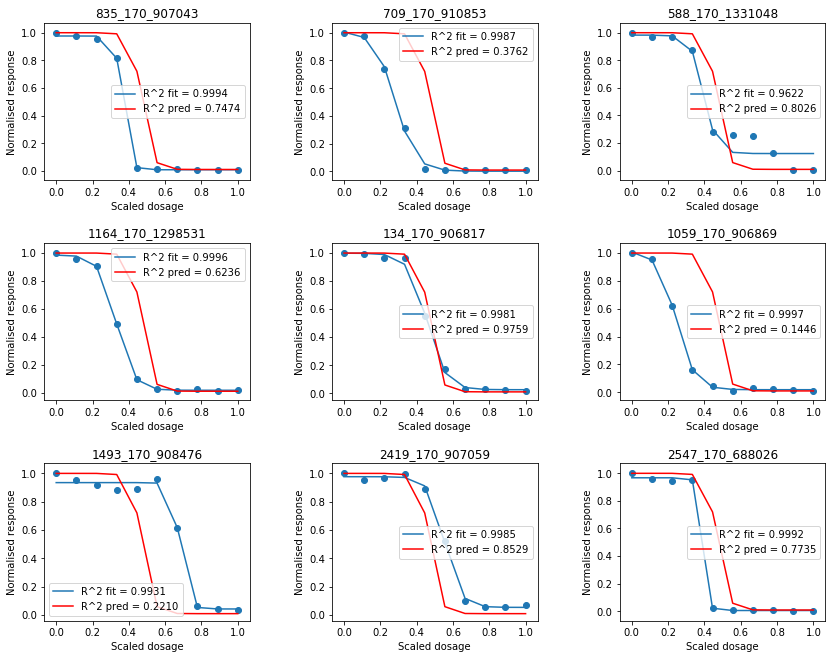

In [14]:
df = short_test
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, 
                              y_columns = response_norm, indexes=df.index[:9], 
                              fitting_function = fitting_function, fitting_parameters = fitting_cols,
                             pred_fitting_param=pred_fitting_cols)

In [28]:
# x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b
metrics = "mse"
df_errors = ComputeErrorByDrug(short_test, 4, metrics= metrics)
df_errors.describe()

,mse_coef_1,mse_coef_2,mse_coef_3,mse_coef_4
count,11.000000,11.000000,11.000000,11.000000
mean,2.327552,4.929368,383.850782,0.034465
std,4.677204,9.433737,464.659691,0.061508
min,0.007525,0.013851,17.503167,0.003845
25%,0.016609,0.039294,50.415982,0.009580
50%,0.031250,0.057143,105.428730,0.014837
75%,1.405654,5.323002,706.148369,0.020273
max,14.042062,29.067397,1380.047044,0.216245


Mean Squared errors for 11 drugs


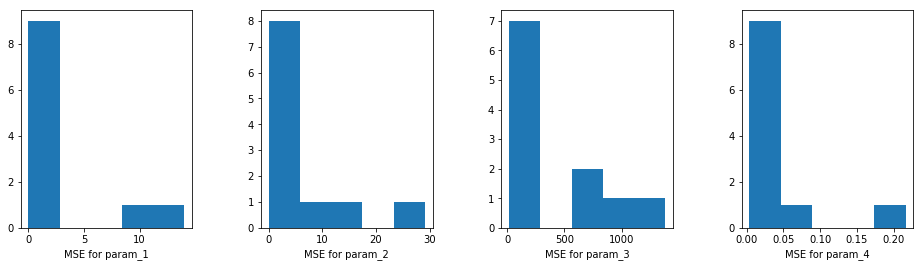

In [29]:
# parameters: x0, L, k, b
# y = 1/ (L + np.exp(-k*(x-x0)))+b

fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_plots= 4
parameters_to_show = [metrics+"_coef_"+str(i+1) for i in range(4)]
print("Mean Squared errors for %d drugs" % df_errors.shape[0])
for i in range(n_plots):
    ax = fig.add_subplot(1, n_plots, i+1)
    ax.hist(df_errors[parameters_to_show[i]], bins=5)
    ax.set_xlabel("MSE for param_"+str(i+1))

**Observations:**
<br> The fitting function was sigmoid_4_parameters: y = 1/ (L + np.exp(-k*(x-x0)))+b
<br> The best predictions are for parameter 4 (b) where the majority of predictions has MSE less than 5
<br> Rather good results are for parameters 1 and 3 with MSE for majority of drugs <20

Mean Absolute errors for 11 drugs


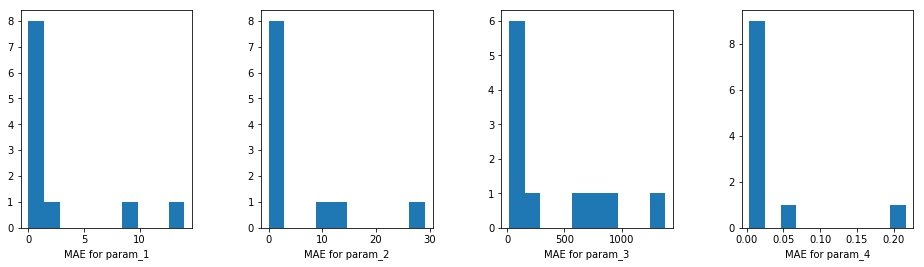

In [30]:
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_plots= 4
print("Mean Absolute errors for %d drugs" % df_errors.shape[0])
parameters_to_show = [metrics+"_coef_"+str(i+1) for i in range(4)]
for i in range(n_plots):
    ax = fig.add_subplot(1, n_plots, i+1)
    ax.hist(df_errors[parameters_to_show[i]])
    ax.set_xlabel("MAE for param_"+str(i+1))

In [31]:
print("Merged data:", short_test.shape[0])
print("Merged and Fitted data with predicted R2>0.9:", short_test[short_test["r2_predicted"]>0.9].shape[0])

Merged data: 300
Merged and Fitted data with predicted R2>0.9: 56


**Observation:**
    19% of the data is predicted well (R2<0.9)

In [39]:
short_test["DRUG_ID"].nunique(), short_test[short_test["r2_predicted"]<0.9]["DRUG_ID"].nunique()

(11, 11)

In [40]:
less_09 = short_test[short_test["r2_predicted"]<=0.9]
above_09 = short_test[short_test["r2_predicted"]>0.9]

In [41]:
d1 = above_09.groupby("DRUG_ID")[["COSMIC_ID"]].count().reset_index()
d2 = less_09.groupby("DRUG_ID")[["COSMIC_ID"]].count().reset_index()
compare_df = pd.merge(left = d1, right = d2, how= "outer", on = "DRUG_ID").fillna(0).rename(columns = {"COSMIC_ID_x": "above_09", "COSMIC_ID_y": "less_09"})
compare_df["sum"] = compare_df["above_09"]+compare_df["less_09"]
compare_df["percent_success"] = compare_df["above_09"]*100/(compare_df["sum"])
compare_df = pd.merge(left = compare_df, right = drug_features, how= "left", on = "DRUG_ID")
compare_df.sort_values(by="percent_success", ascending=False)

,DRUG_ID,above_09,less_09,sum,percent_success,Drug Name,Synonyms,Target,Target Pathway
5,273,15.0,17,32.0,46.875000,CUDC-101,CUDC 101,"HDAC1-10, EGFR, ERBB2",Other
3,219,9.0,17,26.0,34.615385,AT-7519,AT7519,"CDK1, CDK2, CDK4, CDK6, CDK9",Cell cycle
6,276,10.0,20,30.0,33.333333,CAY10603,-,"HDAC1, HDAC6",Chromatin histone acetylation
0,170,9.0,22,31.0,29.032258,Shikonin,Anchusin,not defined,Other
7,346,4.0,14,18.0,22.222222,THZ-2-102-1,-,CDK7,Cell cycle
1,173,3.0,13,16.0,18.750000,FH535,-,"PPARgamma, PPARdelta",WNT signaling
4,272,5.0,28,33.0,15.151515,AR-42,"HDAC-42, AR 42, AR42",HDAC1,Chromatin histone acetylation
2,200,1.0,26,27.0,3.703704,Dacinostat,"NVP-LAQ824, LAQ824",HDAC1,Chromatin histone acetylation
8,180,0.0,22,22.0,0.000000,Thapsigargin,Octanoic acid,SERCA,Other
9,274,0.0,30,30.0,0.000000,Belinostat,"PXD101, PXD-101",HDAC1,Chromatin histone acetylation


Number of drugs with number of good predictions above 70%: 0


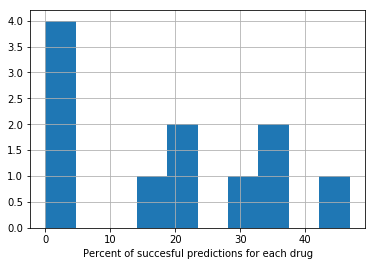

In [42]:
print("Number of drugs with number of good predictions above 70%:", sum(compare_df["percent_success"]>70))
compare_df["percent_success"].hist()
plt.xlabel("Percent of succesful predictions for each drug");

In [43]:
l1 = above_09.groupby("COSMIC_ID")[["DRUG_ID"]].count().reset_index()
l2 = less_09.groupby("COSMIC_ID")[["DRUG_ID"]].count().reset_index()

compare_line = pd.merge(left = l1, right = l2, how= "outer", on = "COSMIC_ID").fillna(0).rename(columns = {"DRUG_ID_x": "above_09", "DRUG_ID_y": "less_09"})
print(compare_line.shape)
compare_line["sum"] = compare_line["above_09"]+compare_line["less_09"]
compare_line["percent_success"] = compare_line["above_09"]*100/(compare_line["sum"])
compare_line[compare_line["sum"]>5].sort_values(by="percent_success", ascending=False)

(262, 3)


,COSMIC_ID,above_09,less_09,sum,percent_success


In [44]:
compare_line[compare_line["percent_success"]==0].shape[0]

208